# MobileNet

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import urllib.request
import tarfile

# URL del dataset
url = "http://download.tensorflow.org/example_images/flower_photos.tgz"

# Percorso di destinazione per il download
file_name = "flower_photos.tgz"

# Download del file
urllib.request.urlretrieve(url, file_name)

# Estrazione del file
tar = tarfile.open(file_name)
tar.extractall()
tar.close()

Import libraries

In [4]:
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
import zipfile
from shutil import copyfile
from time import time
import numpy as np
import random as python_random
from tensorflow.keras import layers
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random as python_random
np.random.seed(0)
python_random.seed(0)
tf.random.set_seed(0)

Split the dataset in train (70%) validation (20%) and test (10%).

In [5]:
!pip install split-folders
import splitfolders
splitfolders.ratio('flower_photos', output="output", seed=1337, ratio=(0.7, 0.2, 0.1))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 3670 files [00:00, 4833.39 files/s]


Define the variables of the paths to train, validation and test.

In [6]:
path_train='/content/output/train/'
path_val='/content/output/val/'
path_test='/content/output/test/'

Define train, validation and test variables.

In [7]:
train_dataset = keras.preprocessing.image_dataset_from_directory(path_train,
                                                                 image_size=(224,224),
                                                                 color_mode='rgb',
                                                                 label_mode='categorical',
                                                                 batch_size=32,
                                                                 validation_split = False,
                                                                 shuffle=True,
                                                                 seed=1)

Found 2567 files belonging to 5 classes.


In [8]:
val_dataset = keras.preprocessing.image_dataset_from_directory(path_val,
                                                                 image_size=(224,224),
                                                                 color_mode='rgb',
                                                                 label_mode='categorical',
                                                                 batch_size=32,
                                                                 validation_split = False,
                                                                 shuffle=True,
                                                                 seed=1)

Found 731 files belonging to 5 classes.


In [9]:
test_dataset = keras.preprocessing.image_dataset_from_directory(path_test,
                                                                 image_size=(224,224),
                                                                 color_mode='rgb',
                                                                 label_mode='categorical',
                                                                 batch_size=32,
                                                                 validation_split = False,
                                                                 shuffle=True,
                                                                 seed=1)

Found 372 files belonging to 5 classes.


In [10]:
class_names = train_dataset.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


Define data augmentation:

In [11]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

Define the number of classes:

In [12]:
num_classes=5

# Net with Adam optimizer and Learning rate 0.01, 0.001, 0001.

1. regularizer->0.001

2. number of nodes in the dense layer->512

3. Dropout->0.5

In [13]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Definisci il learning rates
learning_rates = [0.01, 0.001, 0.0001]

# Lista per memorizzare le storie di addestramento per ogni allenamento
historiesAdam = []
evaluate_testAdamlr=[]

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Ciclo su diversi numeri di nodi nel layer denso finale
for lr in learning_rates:
    # Crea il modello
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False
    regularization = tf.keras.regularizers.l2(0.001)
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = inputs
    x = data_augmentation(x)
    x = base_model(x)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu',kernel_regularizer=regularization)(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=predictions)
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    # Stampa un riassunto del modello
    model.summary()

# Definisci il percorso dei dati
    data_dir = '/content/output'
    train_dir = data_dir + '/train'
    valid_dir = data_dir + '/val'
    test_dir = data_dir + '/test'

# Crea i generatori di immagini per l'addestramento e la validazione senza data augmentation
    train_datagen = ImageDataGenerator(rescale=1./255)
    val_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)

# Imposta i generatori di dati
    batch_size = 32
    train_generator = train_datagen.flow_from_directory(
      train_dir,
      target_size=(224, 224),
      batch_size=batch_size,
      class_mode='categorical'
)

    val_generator = val_datagen.flow_from_directory(
      valid_dir,
      target_size=(224,224),
      batch_size=batch_size,
      class_mode='categorical'
)

    test_generator = test_datagen.flow_from_directory(
      test_dir,
      target_size=(224, 224),
      batch_size=batch_size,
      class_mode='categorical'
)
    # Addestra il modello
    historyAdam = model.fit(
        train_generator,
        epochs=40,
        validation_data=val_generator,
        callbacks=[callback]
    )

    # Aggiungi la storia di addestramento alla lista
    historiesAdam.append(historyAdam)
    evaluate = loss, accuracy = model.evaluate(test_generator)

    evaluate_testAdamlr.append(evaluate)
    model.save('gdrive/MyDrive/MobileNet_Adam_lr{}.h5'.format(lr))


17225924/17225924 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                

In [16]:
print(evaluate_testAdamlr)

[[0.9024366736412048, 0.9059139490127563], [0.5610947012901306, 0.9220430254936218], [0.7195874452590942, 0.9274193644523621]]


#  Validation vs train plot changing learning rate

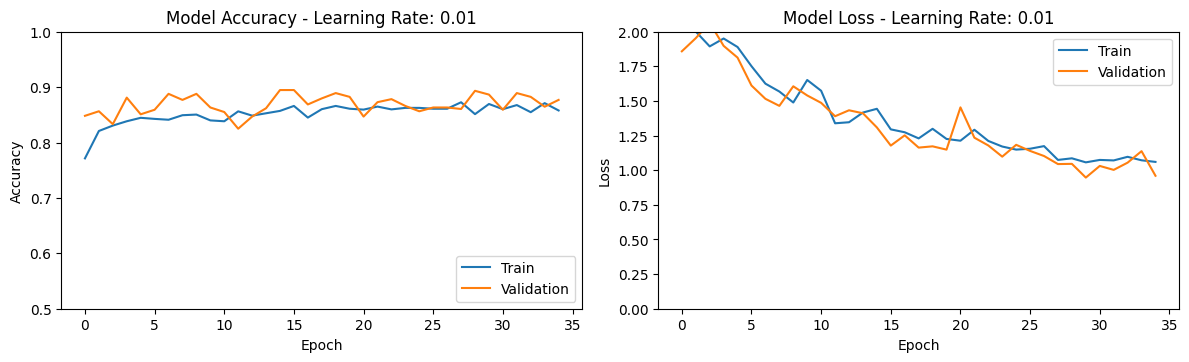

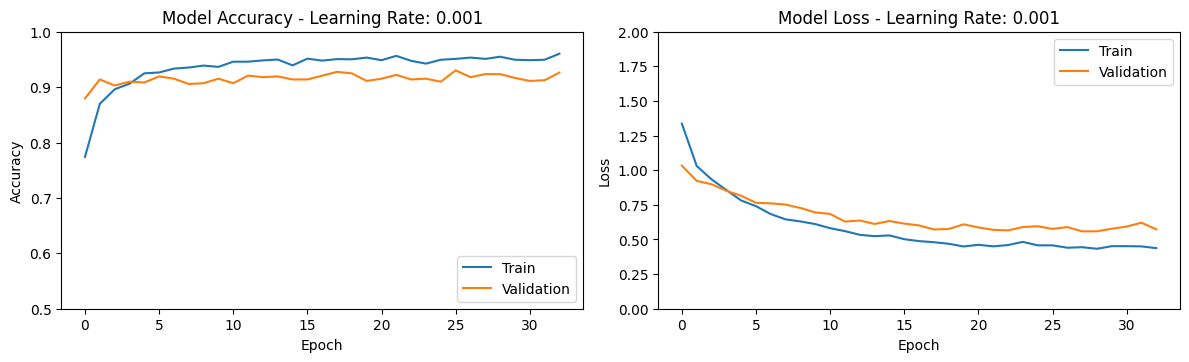

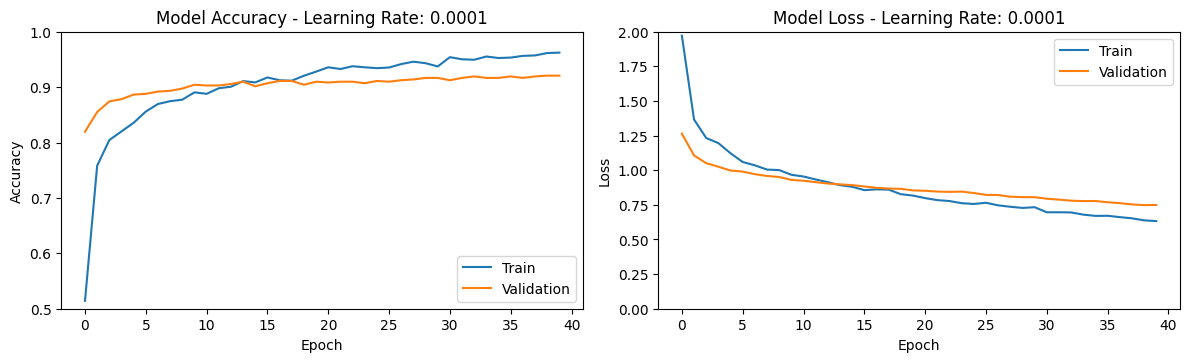

 Learning Rate  Accuracy Diff Mean  Loss Diff Mean
        0.0100              0.0208          0.0920
        0.0010              0.0307          0.1093
        0.0001              0.0351          0.0903


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Creazione del DataFrame per la tabella finale
table_data = {'Learning Rate': learning_rates, 'Accuracy Diff Mean': [], 'Loss Diff Mean': []}

# Plot delle curve di accuracy e loss per ogni storia di addestramento
for i, historyAdam in enumerate(historiesAdam):
    lr = learning_rates[i]
    # Calcolo della media delle differenze tra le accuracy
    train_acc_diff = np.abs(np.array(historyAdam.history['accuracy']) - np.array(historyAdam.history['val_accuracy']))
    avg_acc_diff = np.mean(train_acc_diff)

    # Calcolo della media delle differenze tra le loss
    train_loss_diff = np.abs(np.array(historyAdam.history['loss']) - np.array(historyAdam.history['val_loss']))
    avg_loss_diff = np.mean(train_loss_diff)

    # Aggiunta dei valori nella tabella
    table_data['Accuracy Diff Mean'].append(avg_acc_diff)
    table_data['Loss Diff Mean'].append(avg_loss_diff)

    # Grafico dell'accuracy e della loss
    plt.figure(figsize=(12, 10))

    # Accuracy
    plt.subplot(3, 2, 1)
    plt.plot(historyAdam.history['accuracy'])
    plt.plot(historyAdam.history['val_accuracy'])
    plt.title(f'Model Accuracy - Learning Rate: {lr}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.ylim([0.5, 1])

    # Legenda Accuracy
    acc_legend_text = ['Train', 'Validation']
    plt.legend(acc_legend_text, loc='lower right')


    # Loss
    plt.subplot(3, 2, 2)
    plt.plot(historyAdam.history['loss'])
    plt.plot(historyAdam.history['val_loss'])
    plt.title(f'Model Loss - Learning Rate: {lr}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.ylim([0, 2])

    # Legenda Loss
    loss_legend_text = ['Train', 'Validation']
    plt.legend(loss_legend_text, loc='upper right')

    #plot

    plt.tight_layout()
    plt.show()

# Creazione del DataFrame finale
table_df = pd.DataFrame(table_data)

# Stampa della tabella con formattazione
print(table_df.to_string(index=False, float_format='%.4f'))


# Net with RMSProp optimizer and Learning rate 0.01, 0.001, 0001.

1. regularizer->0.001

2. number of nodes in the dense layer->512

3. Dropout->0.5

In [18]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Definisci il learning rates
learning_rates = [0.01, 0.001, 0.0001]

# Lista per memorizzare le storie di addestramento per ogni allenamento
historiesRMSprop = []
evaluate_testRMSproplr=[]

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Ciclo su diversi learning rates:
for lr in learning_rates:
    # Creo il modello
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False
    regularization = tf.keras.regularizers.l2(0.001)
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = inputs
    x = data_augmentation(x)
    x = base_model(x)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu',kernel_regularizer=regularization)(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=predictions)
    optimizer = RMSprop(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    # Stampa un riassunto del modello
    model.summary()

# Definisci il percorso dei dati
    data_dir = '/content/output'
    train_dir = data_dir + '/train'
    valid_dir = data_dir + '/val'
    test_dir = data_dir + '/test'

# Crea i generatori di immagini per l'addestramento e la validazione con rescaling
    train_datagen = ImageDataGenerator(rescale=1./255)
    val_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)

# Imposta i generatori di dati
    batch_size = 32
    train_generator = train_datagen.flow_from_directory(
      train_dir,
      target_size=(224, 224),
      batch_size=batch_size,
      class_mode='categorical'
)

    val_generator = val_datagen.flow_from_directory(
      valid_dir,
      target_size=(224,224),
      batch_size=batch_size,
      class_mode='categorical'
)
    test_generator = test_datagen.flow_from_directory(
      test_dir,
      target_size=(224, 224),
      batch_size=batch_size,
      class_mode='categorical'
)
    # Addestra il modello
    historyRMSprop = model.fit(
        train_generator,
        epochs=40,
        validation_data=val_generator,
        callbacks=[callback]
    )

    # Aggiungi la storia di addestramento alla lista
    historiesRMSprop.append(historyRMSprop)
    evaluate = loss, accuracy = model.evaluate(test_generator)

    evaluate_testRMSproplr.append(evaluate)
    model.save('drive/MyDrive/MobileNet_RMSprop_lr{}.h5'.format(lr))


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, None)  0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_3   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_6 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                           

In [22]:
print(evaluate_testRMSproplr)

[[0.6511191725730896, 0.9059139490127563], [0.47499871253967285, 0.9274193644523621], [0.6562018990516663, 0.9220430254936218]]


#  Validation vs train plot changing learning rate

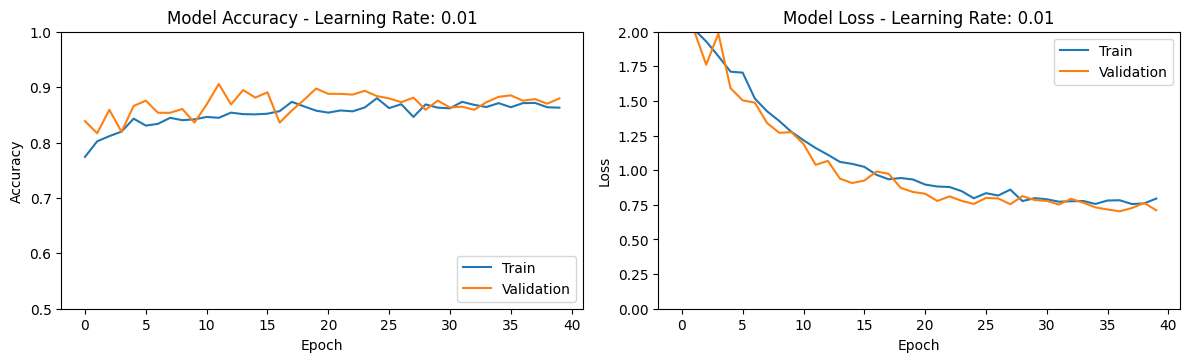

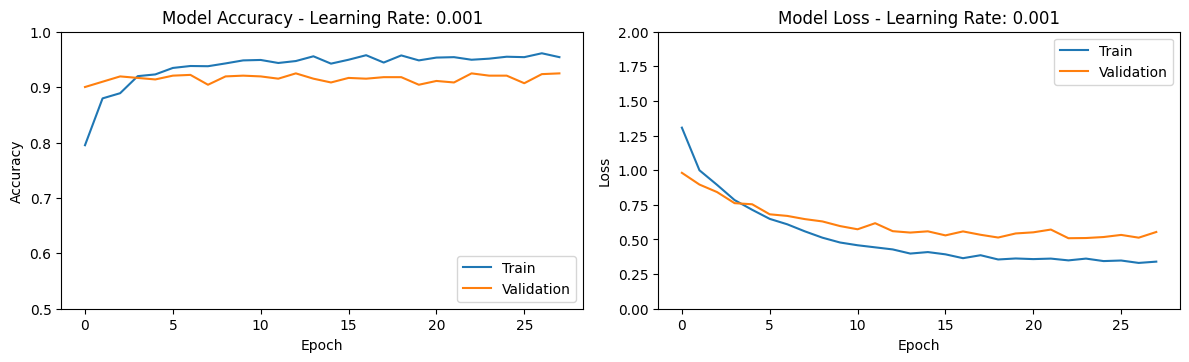

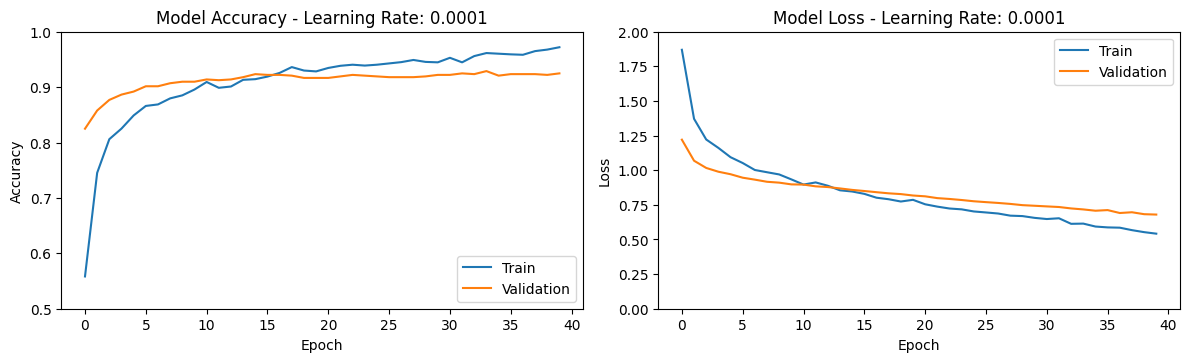

 Learning Rate  Accuracy Diff Mean  Loss Diff Mean
        0.0100              0.0212          0.0666
        0.0010              0.0330          0.1417
        0.0001              0.0342          0.0975


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Creazione del DataFrame per la tabella finale
table_data = {'Learning Rate': learning_rates, 'Accuracy Diff Mean': [], 'Loss Diff Mean': []}

# Plot delle curve di accuracy e loss per ogni storia di addestramento
for i, historyRMSprop in enumerate(historiesRMSprop):
    lr = learning_rates[i]
    # Calcolo della media delle differenze tra le accuracy
    train_acc_diff = np.abs(np.array(historyRMSprop.history['accuracy']) - np.array(historyRMSprop.history['val_accuracy']))
    avg_acc_diff = np.mean(train_acc_diff)

    # Calcolo della media delle differenze tra le loss
    train_loss_diff = np.abs(np.array(historyRMSprop.history['loss']) - np.array(historyRMSprop.history['val_loss']))
    avg_loss_diff = np.mean(train_loss_diff)

    # Aggiunta dei valori nella tabella
    table_data['Accuracy Diff Mean'].append(avg_acc_diff)
    table_data['Loss Diff Mean'].append(avg_loss_diff)

    # Grafico dell'accuracy e della loss
    plt.figure(figsize=(12, 10))

    # Accuracy
    plt.subplot(3, 2, 1)
    plt.plot(historyRMSprop.history['accuracy'])
    plt.plot(historyRMSprop.history['val_accuracy'])
    plt.title(f'Model Accuracy - Learning Rate: {lr}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.ylim([0.5, 1])

    # Legenda Accuracy
    acc_legend_text = ['Train', 'Validation']
    plt.legend(acc_legend_text, loc='lower right')


    # Loss
    plt.subplot(3, 2, 2)
    plt.plot(historyRMSprop.history['loss'])
    plt.plot(historyRMSprop.history['val_loss'])
    plt.title(f'Model Loss - Learning Rate: {lr}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.ylim([0, 2])

    # Legenda Loss
    loss_legend_text = ['Train', 'Validation']
    plt.legend(loss_legend_text, loc='upper right')

    plt.tight_layout()
    plt.show()

# Creazione del DataFrame finale
table_df = pd.DataFrame(table_data)

# Stampa della tabella con formattazione migliore
print(table_df.to_string(index=False, float_format='%.4f'))

# Comparison between plots of accuracy and loss on validation set

- Adam, RMSProp

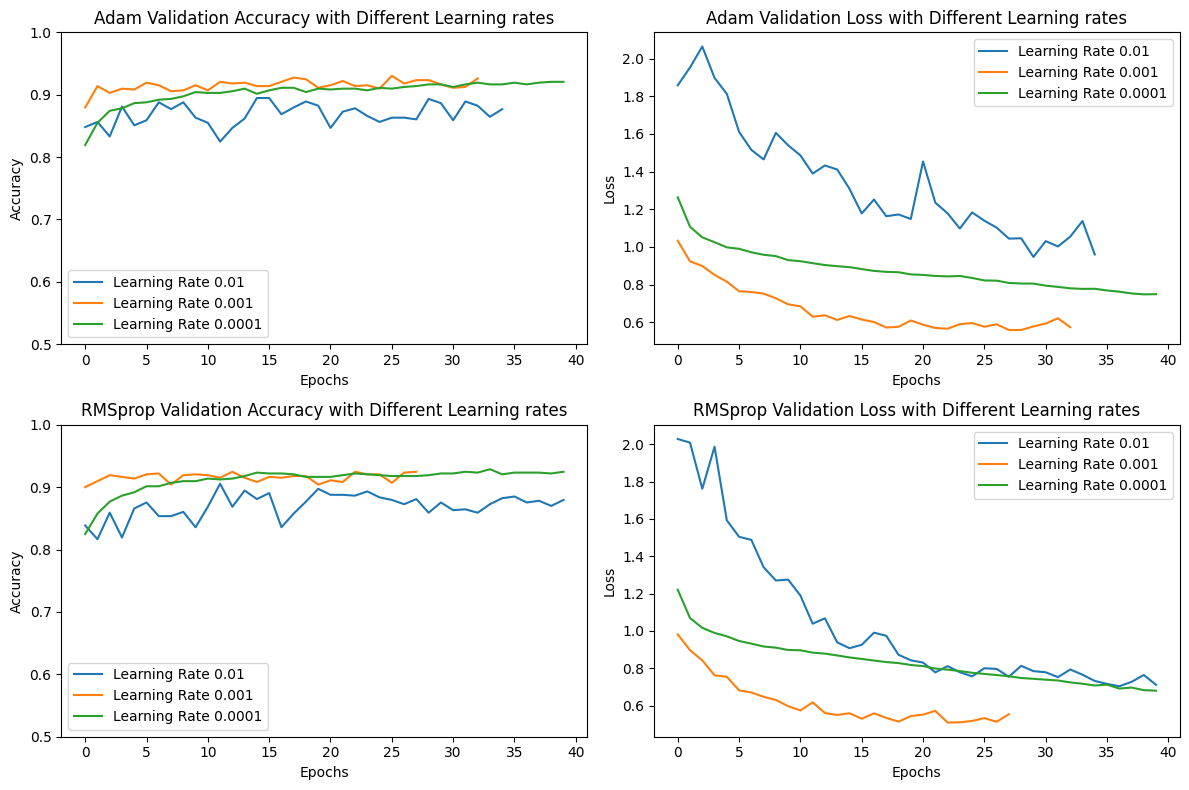

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Grafico delle accuracy e loss sul validation set Adam
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Grafico delle accuracy sul validation set Adam
for i, historyAdam in enumerate(historiesAdam):
    ax = axes[0, 0]
    ax.plot(historyAdam.history['val_accuracy'], label='Learning Rate {}'.format(learning_rates[i]))
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_ylim([0.5, 1])
ax.set_title('Adam Validation Accuracy with Different Learning rates')
ax.legend()

# Grafico delle loss sul validation set Adam
for i, historyAdam in enumerate(historiesAdam):
    ax = axes[0, 1]
    ax.plot(historyAdam.history['val_loss'], label='Learning Rate {}'.format(learning_rates[i]))
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('Adam Validation Loss with Different Learning rates')
ax.legend()

# Grafico delle accuracy sul validation set RMSprop
for i, historyRMSprop in enumerate(historiesRMSprop):
    ax = axes[1, 0]
    ax.plot(historyRMSprop.history['val_accuracy'], label='Learning Rate {}'.format(learning_rates[i]))
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_ylim([0.5, 1])
ax.set_title('RMSprop Validation Accuracy with Different Learning rates')
ax.legend()

# Grafico delle loss sul validation set RMSprop
for i, historyRMSprop in enumerate(historiesRMSprop):
    ax = axes[1, 1]
    ax.plot(historyRMSprop.history['val_loss'], label='Learning Rate {}'.format(learning_rates[i]))
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('RMSprop Validation Loss with Different Learning rates')
ax.legend()

plt.tight_layout()
plt.show()


# Adam vs RMSProp optimizer

- Final plot of the best accuracy and Loss on validation set

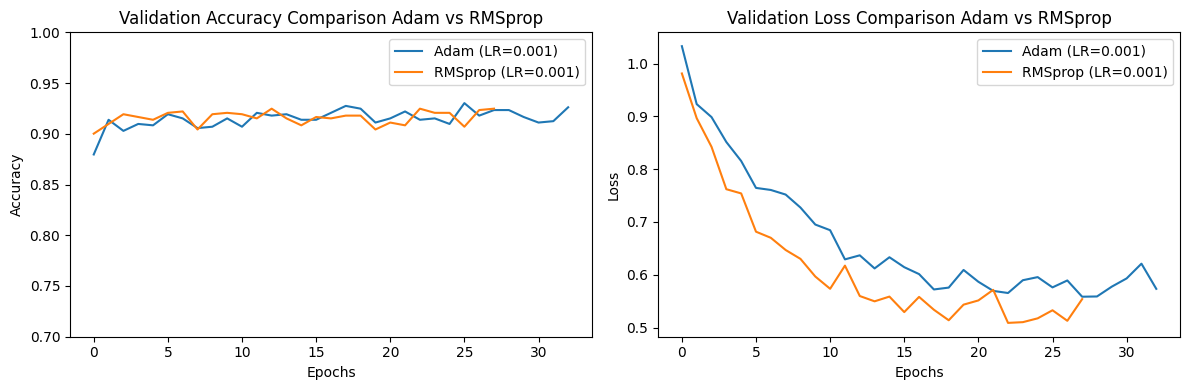

In [24]:
plt.figure(figsize=(12, 4))

# Accuracy Comparison
plt.subplot(1, 2, 1)
plt.plot(historiesAdam[1].history['val_accuracy'], label='Adam (LR=0.001)')
plt.plot(historiesRMSprop[1].history['val_accuracy'], label='RMSprop (LR=0.001)')
plt.ylim(0.7, 1)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Comparison Adam vs RMSprop')
plt.legend()

# Loss Comparison
plt.subplot(1, 2, 2)
plt.plot(historiesAdam[1].history['val_loss'], label='Adam (LR=0.001)')
plt.plot(historiesRMSprop[1].history['val_loss'], label='RMSprop (LR=0.001)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss Comparison Adam vs RMSprop')
plt.legend()

plt.tight_layout()
plt.show()


# #-----------------------------------------------

# Net with Adam optimizer and Regularizer 0.1, 0.01, 0.001, 0,0001.

1. learning rate->0.001 (best learning rate)

2. number of nodes in the dense layer->512

3. Dropout->0.5

In [25]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Definisci i regolarizzatori da utilizzare
regularizers = [0.1, 0.01, 0.001, 0.0001]

# Lista per memorizzare le storie di addestramento per ogni regolarizzatore
historiesAdamreg = []
evaluate_testAdamreg=[]

#Definisco il miglior learning rate
best_learningrAdam= 0.001

# Definisci il percorso dei dati
data_dir = '/content/output'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/val'
test_dir = data_dir + '/test'

# Crea i generatori di immagini per l'addestramento e la validazione senza data augmentation

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Imposta i generatori di dati

batch_size = 32
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

# Esegui l'addestramento con ogni regolarizzatore

for regularization_value in regularizers:
    # Crea il modello
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False
    inputs = tf.keras.Input(shape=(224, 224, 3))
    regularization = tf.keras.regularizers.l2(regularization_value)
    x = inputs
    x = data_augmentation(x)
    x = base_model(x)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu', kernel_regularizer=regularization)(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=predictions)

    model.compile(optimizer=Adam(learning_rate=best_learningrAdam), loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    # Addestra il modello
    historyAdam = model.fit(
        train_generator,
        epochs=40,
        validation_data=val_generator,
        callbacks=[callback]
    )

    # Aggiungi la storia di addestramento alla lista
    historiesAdamreg.append(historyAdam)
    #evaluation
    evaluate = loss, accuracy = model.evaluate(test_generator)

    evaluate_testAdamreg.append(evaluate)
    model.save('drive/MyDrive/MobileNet_Adam_reg{}.h5'.format(regularization_value))


Found 2567 images belonging to 5 classes.
Found 731 images belonging to 5 classes.
Found 372 images belonging to 5 classes.
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, None)  0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_6   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_12 (Bat  (None, 1024)             4096      
 

In [26]:
print(evaluate_testAdamreg)

[[1.4620009660720825, 0.8951612710952759], [0.8762072324752808, 0.9032257795333862], [0.5880976319313049, 0.9086021780967712], [0.3641822636127472, 0.9032257795333862]]


#  Validation vs train plot changing regularizer

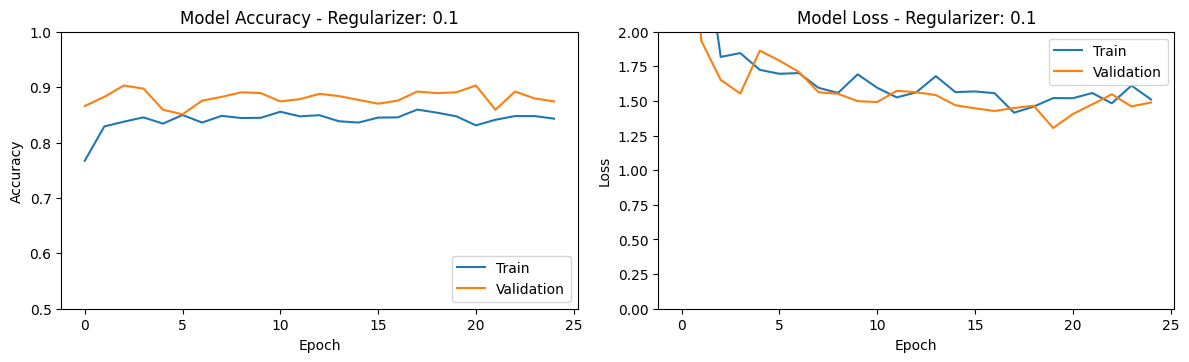

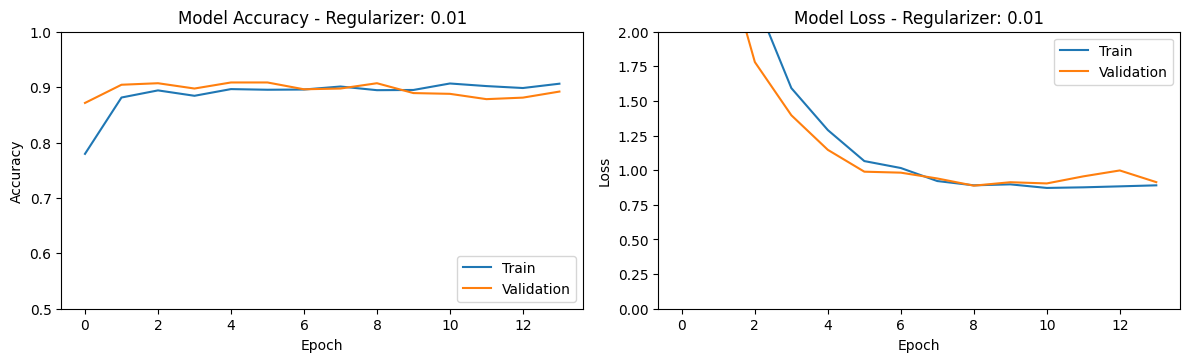

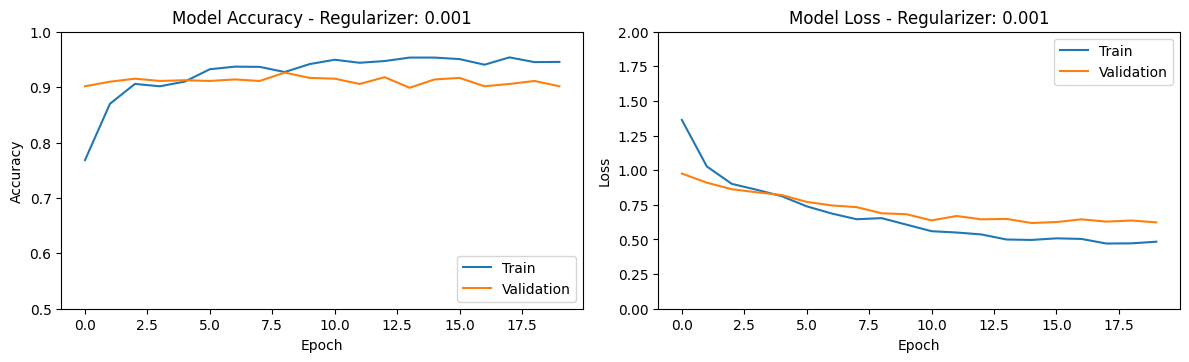

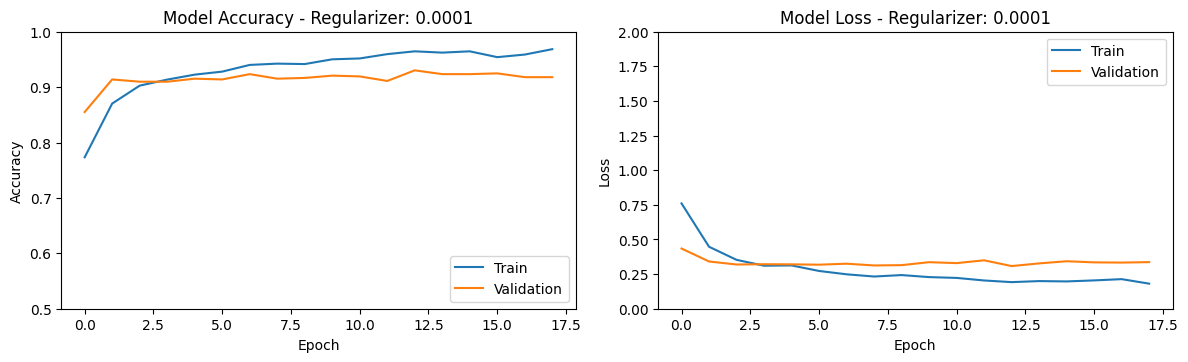

 Regularizers  Accuracy Diff Mean  Loss Diff Mean
       0.1000              0.0400          0.8759
       0.0100              0.0187          0.2637
       0.0010              0.0342          0.1078
       0.0001              0.0318          0.1062


In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Creazione del DataFrame per la tabella finale

table_data = {'Regularizers': regularizers, 'Accuracy Diff Mean': [], 'Loss Diff Mean': []}
# Plot delle curve di accuracy e loss per ogni storia di addestramento
for i, historyAdam in enumerate(historiesAdamreg):
    regularizer = regularizers[i]
    # Calcolo della media delle differenze tra le accuracy
    train_acc_diff = np.abs(np.array(historyAdam.history['accuracy']) - np.array(historyAdam.history['val_accuracy']))
    avg_acc_diff = np.mean(train_acc_diff)

    # Calcolo della media delle differenze tra le loss
    train_loss_diff = np.abs(np.array(historyAdam.history['loss']) - np.array(historyAdam.history['val_loss']))
    avg_loss_diff = np.mean(train_loss_diff)

    # Aggiunta dei valori nella tabella
    table_data['Accuracy Diff Mean'].append(avg_acc_diff)
    table_data['Loss Diff Mean'].append(avg_loss_diff)

    # Grafico dell'accuracy e della loss
    plt.figure(figsize=(12, 10))

    # Accuracy
    plt.subplot(3, 2, 1)
    plt.plot(historyAdam.history['accuracy'])
    plt.plot(historyAdam.history['val_accuracy'])
    plt.title(f'Model Accuracy - Regularizer: {regularizer}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.ylim([0.5, 1])

    # Legenda Accuracy
    acc_legend_text = ['Train', 'Validation']
    plt.legend(acc_legend_text, loc='lower right')


    # Loss
    plt.subplot(3, 2, 2)
    plt.plot(historyAdam.history['loss'])
    plt.plot(historyAdam.history['val_loss'])
    plt.title(f'Model Loss - Regularizer: {regularizer}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.ylim([0, 2])

    # Legenda Loss
    loss_legend_text = ['Train', 'Validation']
    plt.legend(loss_legend_text, loc='upper right')

    plt.tight_layout()
    plt.show()

# Creazione del DataFrame finale
table_df = pd.DataFrame(table_data)

# Stampa della tabella con formattazione migliore
print(table_df.to_string(index=False, float_format='%.4f'))


# Net with RMSprop optimizer and Regularizer 0.1, 0.01, 0.001, 0,0001.

1. learning rate->0.001 (best learning rate)

2. number of nodes in the dense layer->512

3. Dropout->0.5

In [28]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Definisci i regolarizzatori da utilizzare
regularizers = [0.1, 0.01, 0.001, 0.0001]

# Lista per memorizzare le storie di addestramento per ogni regolarizzatore
historiesRMSpropreg = []
evaluate_testRMSpropreg=[]

# Definisco il miglior learning rate

best_learningrRMSprop= 0.001

# Definisci il percorso dei dati
data_dir = '/content/output'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/val'
test_dir = data_dir + '/test'

# Crea i generatori di immagini per l'addestramento e la validazione senza data augmentation

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Imposta i generatori di dati

batch_size = 32
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

# Esegui l'addestramento con ogni regolarizzatore
for regularization_value in regularizers:
    # Crea il modello
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False
    inputs = tf.keras.Input(shape=(224, 224, 3))
    regularization = tf.keras.regularizers.l2(regularization_value)
    x = inputs
    x = data_augmentation(x)
    x = base_model(x)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu', kernel_regularizer=regularization)(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(optimizer=RMSprop(learning_rate=best_learningrRMSprop), loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    # Addestra il modello
    historyRMSprop = model.fit(
        train_generator,
        epochs=40,
        validation_data=val_generator,
        callbacks=[callback]
    )

    # Aggiungi la storia di addestramento alla lista
    historiesRMSpropreg.append(historyRMSprop)
    evaluate = loss, accuracy = model.evaluate(test_generator)

    evaluate_testRMSpropreg.append(evaluate)
    model.save('drive/MyDrive/MobileNet_RMSprop_reg{}.h5'.format(regularization_value))



Found 2567 images belonging to 5 classes.
Found 731 images belonging to 5 classes.
Found 372 images belonging to 5 classes.
Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, None)  0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_10  (None, 1024)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_20 (Bat  (None, 1024)             4096      


In [29]:
print(evaluate_testRMSpropreg)

[[1.2260205745697021, 0.8709677457809448], [0.7555415630340576, 0.9059139490127563], [0.49361464381217957, 0.9166666865348816], [0.35572758316993713, 0.9086021780967712]]


#  Validation vs train plot changing regularizer

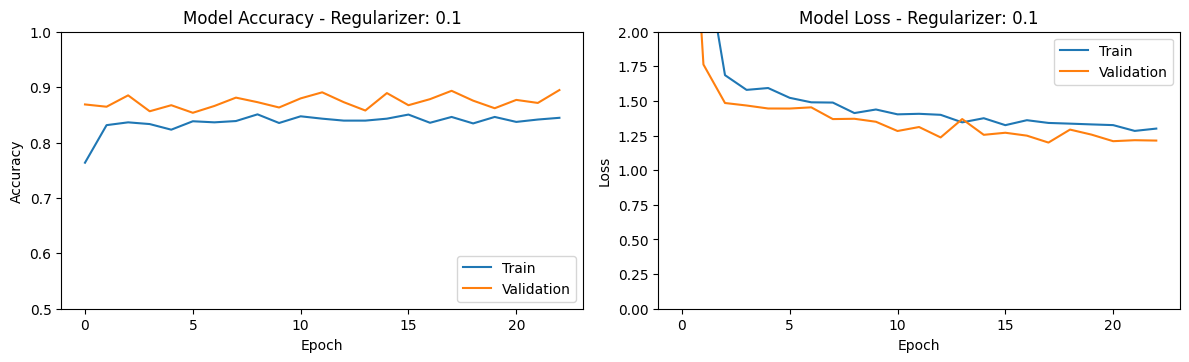

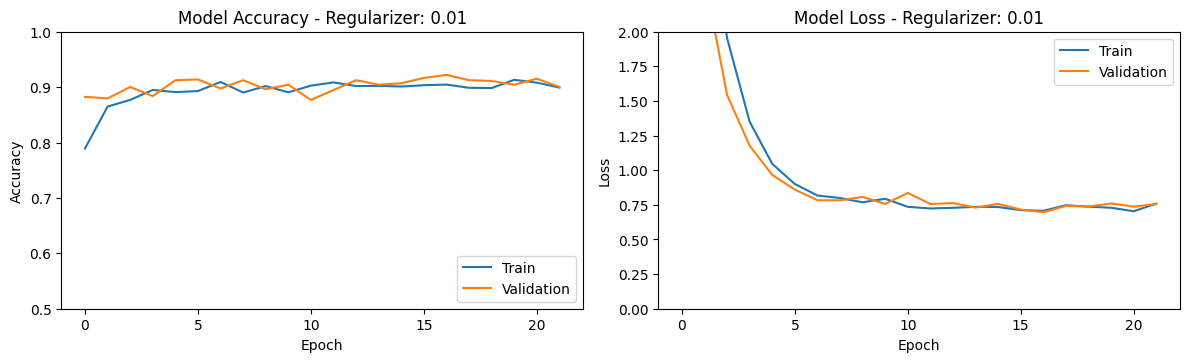

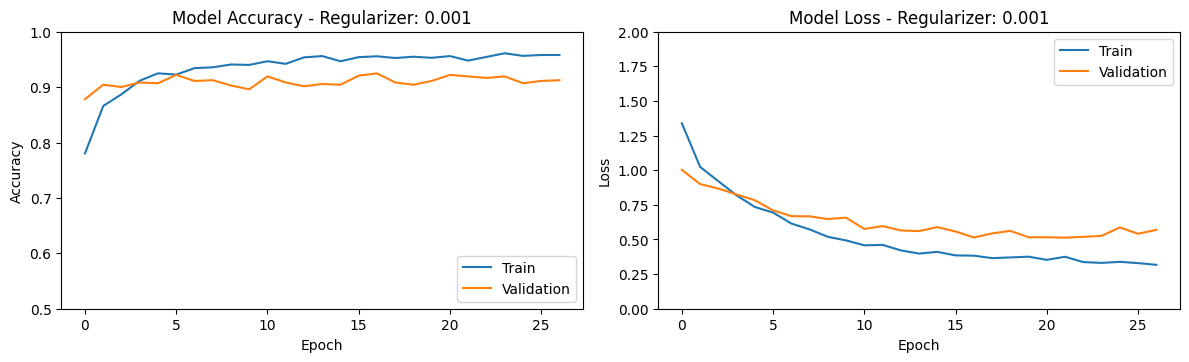

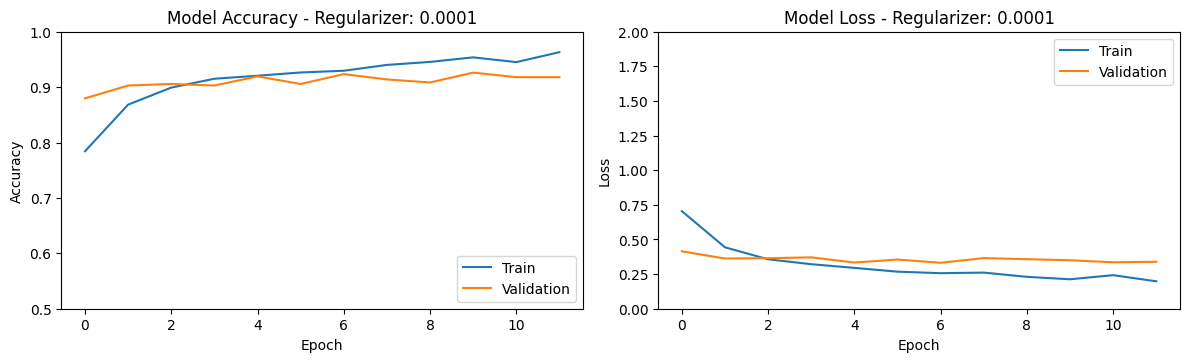

 Regularizers  Accuracy Diff Mean  Loss Diff Mean
       0.1000              0.0371          0.7893
       0.0100              0.0168          0.1636
       0.0010              0.0366          0.1470
       0.0001              0.0283          0.1027


In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Creazione del DataFrame per la tabella finale

table_data = {'Regularizers': regularizers, 'Accuracy Diff Mean': [], 'Loss Diff Mean': []}
# Plot delle curve di accuracy e loss per ogni storia di addestramento
for i, historyRMSprop in enumerate(historiesRMSpropreg):
    regularizer = regularizers[i]
    # Calcolo della media delle differenze tra le accuracy
    train_acc_diff = np.abs(np.array(historyRMSprop.history['accuracy']) - np.array(historyRMSprop.history['val_accuracy']))
    avg_acc_diff = np.mean(train_acc_diff)

    # Calcolo della media delle differenze tra le loss
    train_loss_diff = np.abs(np.array(historyRMSprop.history['loss']) - np.array(historyRMSprop.history['val_loss']))
    avg_loss_diff = np.mean(train_loss_diff)

    # Aggiunta dei valori nella tabella
    table_data['Accuracy Diff Mean'].append(avg_acc_diff)
    table_data['Loss Diff Mean'].append(avg_loss_diff)

    # Grafico dell'accuracy e della loss
    plt.figure(figsize=(12, 10))

    # Accuracy
    plt.subplot(3, 2, 1)
    plt.plot(historyRMSprop.history['accuracy'])
    plt.plot(historyRMSprop.history['val_accuracy'])
    plt.title(f'Model Accuracy - Regularizer: {regularizer}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.ylim([0.5, 1])

    # Legenda Accuracy
    acc_legend_text = ['Train', 'Validation']
    plt.legend(acc_legend_text, loc='lower right')


    # Loss
    plt.subplot(3, 2, 2)
    plt.plot(historyRMSprop.history['loss'])
    plt.plot(historyRMSprop.history['val_loss'])
    plt.title(f'Model Loss - Regularizer: {regularizer}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.ylim([0, 2])

    # Legenda Loss
    loss_legend_text = ['Train', 'Validation']
    plt.legend(loss_legend_text, loc='upper right')

    plt.tight_layout()
    plt.show()

# Creazione del DataFrame finale
table_df = pd.DataFrame(table_data)

# Stampa della tabella con formattazione migliore
print(table_df.to_string(index=False, float_format='%.4f'))


# Comparison between plots of accuracy and loss on validation set

- Adam, RMSProp

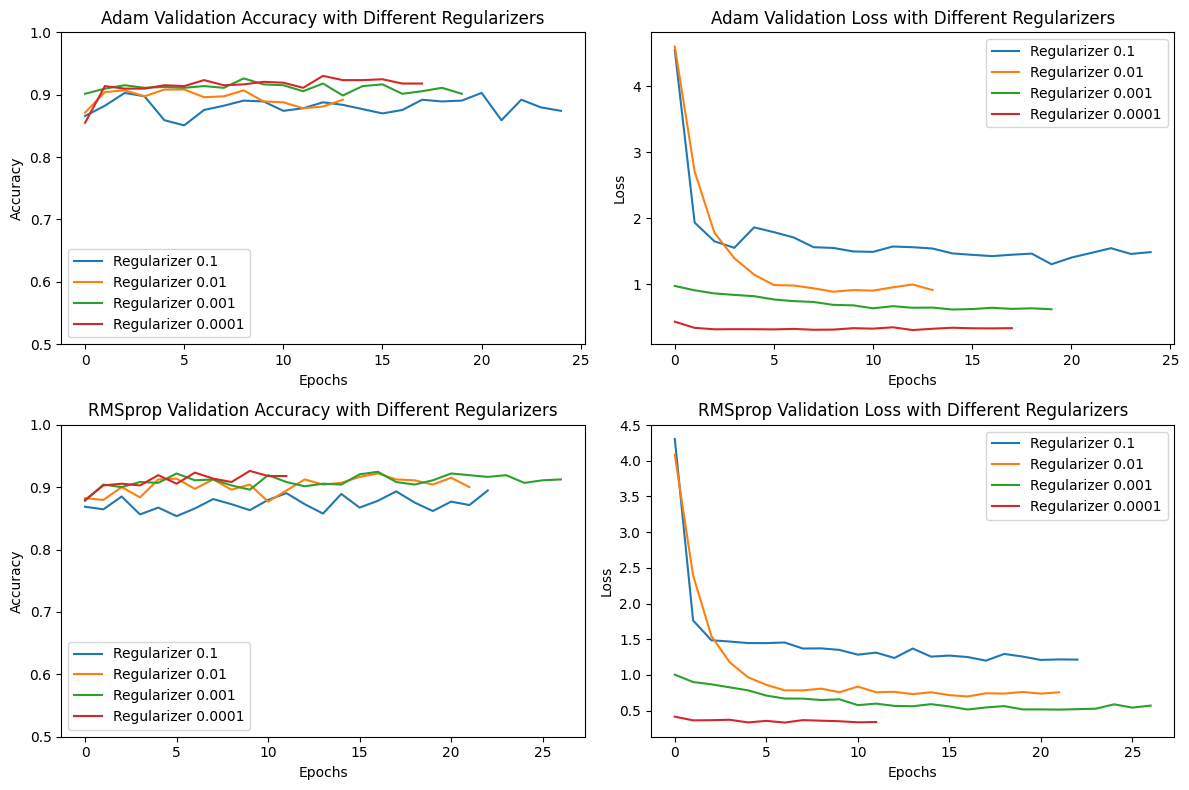

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Grafico delle accuracy e loss sul validation set Adam
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Grafico delle accuracy sul validation set Adam
for i, historyAdam in enumerate(historiesAdamreg):
    ax = axes[0, 0]
    ax.plot(historyAdam.history['val_accuracy'], label='Regularizer {}'.format(regularizers[i]))
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_ylim([0.5, 1])
ax.set_title('Adam Validation Accuracy with Different Regularizers')
ax.legend()

# Grafico delle loss sul validation set Adam
for i, historyAdam in enumerate(historiesAdamreg):
    ax = axes[0, 1]
    ax.plot(historyAdam.history['val_loss'], label='Regularizer {}'.format(regularizers[i]))
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('Adam Validation Loss with Different Regularizers')
ax.legend()

# Grafico delle accuracy sul validation set RMSprop
for i, historyRMSprop in enumerate(historiesRMSpropreg):
    ax = axes[1, 0]
    ax.plot(historyRMSprop.history['val_accuracy'], label='Regularizer {}'.format(regularizers[i]))
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_ylim([0.5, 1])
ax.set_title('RMSprop Validation Accuracy with Different Regularizers')
ax.legend()

# Grafico delle loss sul validation set RMSprop
for i, historyRMSprop in enumerate(historiesRMSpropreg):
    ax = axes[1, 1]
    ax.plot(historyRMSprop.history['val_loss'], label='Regularizer {}'.format(regularizers[i]))
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('RMSprop Validation Loss with Different Regularizers')
ax.legend()

plt.tight_layout()
plt.show()


# Adam vs RMSProp optimizer

- Final plot of the best accuracy and Loss on validation set

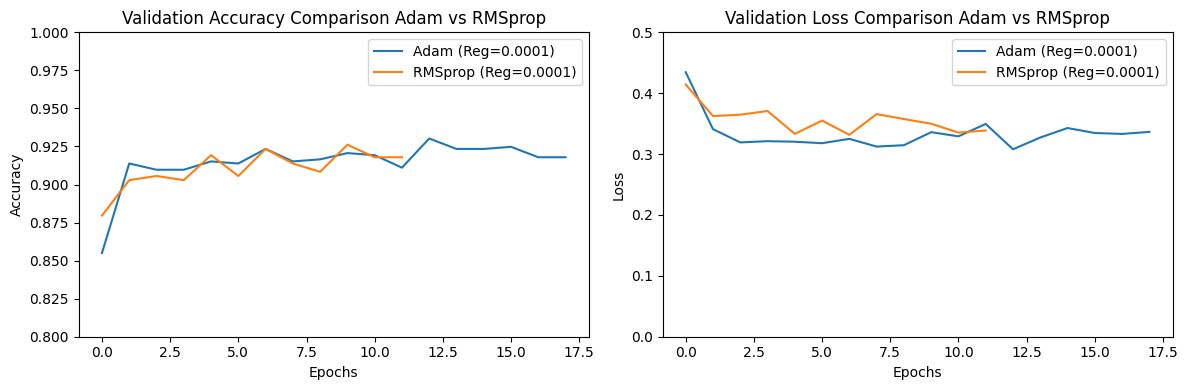

In [32]:
plt.figure(figsize=(12, 4))

# Accuracy Comparison
plt.subplot(1, 2, 1)
plt.plot(historiesAdamreg[3].history['val_accuracy'], label='Adam (Reg=0.0001)')
plt.plot(historiesRMSpropreg[3].history['val_accuracy'], label='RMSprop (Reg=0.0001)')
plt.ylim(0.8, 1)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Comparison Adam vs RMSprop')
plt.legend()

# Loss Comparison
plt.subplot(1, 2, 2)
plt.plot(historiesAdamreg[3].history['val_loss'], label='Adam (Reg=0.0001)')
plt.plot(historiesRMSpropreg[3].history['val_loss'], label='RMSprop (Reg=0.0001)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 0.5)
plt.title('Validation Loss Comparison Adam vs RMSprop')
plt.legend()

plt.tight_layout()
plt.show()

# #-----------------------------------------------

# Net with Adam optimizer and number of nodes in the dense layer 64, 128, 512.

1. learning rate->0.001 (best learning rate)

2. Regularizer->0.0001

3. Dropout->0.5

In [33]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Definisci il numero di nodi nel layer denso finale per ogni allenamento
num_nodes = [64, 128, 512]

# Lista per memorizzare le storie di addestramento per ogni allenamento
historiesAdamdense = []
evaluate_testAdamdense=[]

# Definisco il termine di regularizer migliore

best_regularizerAdam = 0.0001
best_learningrAdam= 0.001
# Definisci il percorso dei dati

data_dir = '/content/output'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/val'
test_dir = data_dir + '/test'

# Crea i generatori di immagini per l'addestramento e la validazione senza data augmentation

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Imposta i generatori di dati

batch_size = 32
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)
# Ciclo su diversi numeri di nodi nel layer denso finale

for nodes in num_nodes:
    # Crea il modello
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False
    inputs = tf.keras.Input(shape=(224, 224, 3))
    regularization = tf.keras.regularizers.l2(best_regularizerAdam)
    x = inputs
    x = base_model(x)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(nodes, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=predictions)
    optimizer = Adam(learning_rate=best_learningrAdam)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    # Addestra il modello
    historyAdam = model.fit(
        train_generator,
        epochs=40,
        validation_data=val_generator,
        callbacks=[callback]
    )

    # Aggiungi la storia di addestramento alla lista
    historiesAdamdense.append(historyAdam)
    #evaluation
    evaluate = loss, accuracy = model.evaluate(test_generator)

    evaluate_testAdamdense.append(evaluate)
    model.save('drive/MyDrive/MobileNet_Adam_denselayer{}.h5'.format(nodes))



Found 2567 images belonging to 5 classes.
Found 731 images belonging to 5 classes.
Found 372 images belonging to 5 classes.
Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_14  (None, 1024)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_28 (Bat  (None, 1024)             4096      
 chNormalization)                                                
                                                                 


In [34]:
print(evaluate_testAdamdense)

[[0.24433483183383942, 0.9112903475761414], [0.24753335118293762, 0.9139785170555115], [0.24199865758419037, 0.9301075339317322]]


#  Validation vs train plot changing the number of nodes in the dense layer

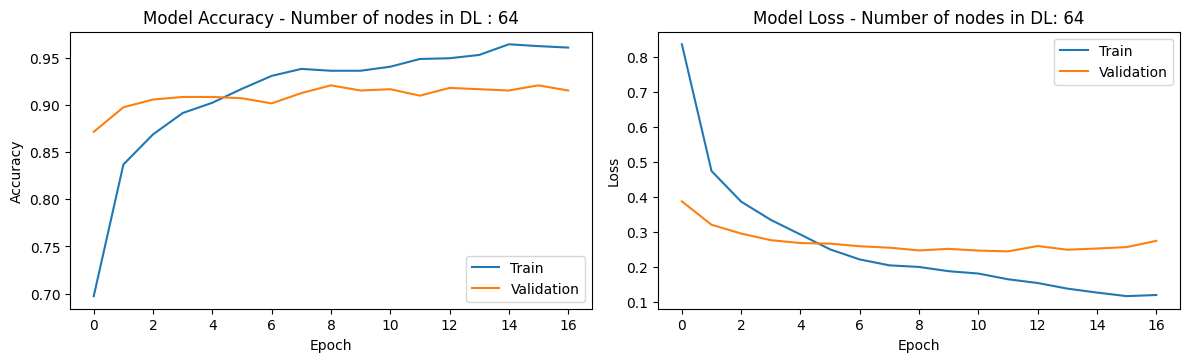

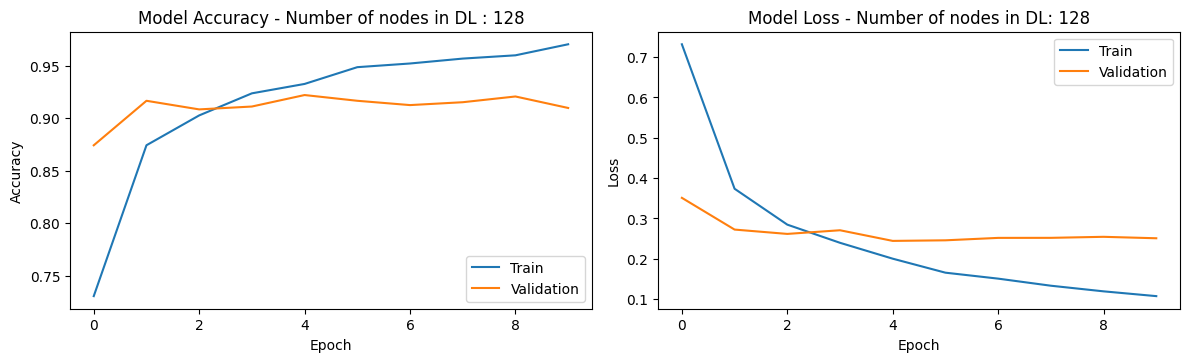

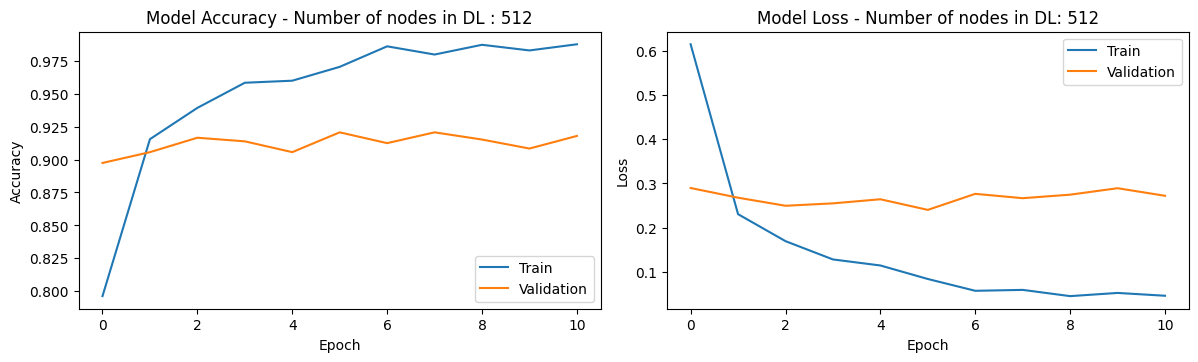

 Number of nodes in DL  Accuracy Diff Mean  Loss Diff Mean
                    64              0.0390          0.1041
                   128              0.0428          0.1158
                   512              0.0574          0.1816


In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Creazione del DataFrame per la tabella finale

table_data = {'Number of nodes in DL': num_nodes, 'Accuracy Diff Mean': [], 'Loss Diff Mean': []}
# Plot delle curve di accuracy e loss per ogni storia di addestramento
for i, historyAdam in enumerate(historiesAdamdense):
    nodes = num_nodes[i]
    # Calcolo della media delle differenze tra le accuracy
    train_acc_diff = np.abs(np.array(historyAdam.history['accuracy']) - np.array(historyAdam.history['val_accuracy']))
    avg_acc_diff = np.mean(train_acc_diff)

    # Calcolo della media delle differenze tra le loss
    train_loss_diff = np.abs(np.array(historyAdam.history['loss']) - np.array(historyAdam.history['val_loss']))
    avg_loss_diff = np.mean(train_loss_diff)

    # Aggiunta dei valori nella tabella
    table_data['Accuracy Diff Mean'].append(avg_acc_diff)
    table_data['Loss Diff Mean'].append(avg_loss_diff)

    # Grafico dell'accuracy e della loss
    plt.figure(figsize=(12, 10))

    # Accuracy
    plt.subplot(3, 2, 1)
    plt.plot(historyAdam.history['accuracy'])
    plt.plot(historyAdam.history['val_accuracy'])
    plt.title(f'Model Accuracy - Number of nodes in DL : {nodes}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')


    # Legenda Accuracy
    acc_legend_text = ['Train', 'Validation']
    plt.legend(acc_legend_text, loc='lower right')


    # Loss
    plt.subplot(3, 2, 2)
    plt.plot(historyAdam.history['loss'])
    plt.plot(historyAdam.history['val_loss'])
    plt.title(f'Model Loss - Number of nodes in DL: {nodes}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')

    # Legenda Loss
    loss_legend_text = ['Train', 'Validation']
    plt.legend(loss_legend_text, loc='upper right')

    plt.tight_layout()
    plt.show()

# Creazione del DataFrame finale
table_df = pd.DataFrame(table_data)

# Stampa della tabella con formattazione migliore
print(table_df.to_string(index=False, float_format='%.4f'))

# Net with RMSProp optimizer and number of nodes in the dense layer 64, 128, 512.

1. learning rate->0.001 (best learning rate)

2. Regularizer->0.0001

3. Dropout->0.5

In [36]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Definisci il numero di nodi nel layer denso finale per ogni allenamento
num_nodes = [64, 128, 512]

# Lista per memorizzare le storie di addestramento per ogni allenamento
historiesRMSpropdense = []
evaluate_testRMSpropdense=[]

# Definisco il termine di regularizer migliore

best_regularizerRMSprop= 0.0001
best_learningrRMSprop=0.001

# Definisci il percorso dei dati

data_dir = '/content/output'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/val'
test_dir = data_dir + '/test'

# Crea i generatori di immagini per l'addestramento e la validazione senza data augmentation

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Imposta i generatori di dati

batch_size = 32
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)
# Ciclo su diversi numeri di nodi nel layer denso finale

for nodes in num_nodes:
    # Crea il modello
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False
    inputs = tf.keras.Input(shape=(224, 224, 3))
    regularization = tf.keras.regularizers.l2(best_regularizerRMSprop)
    x = inputs
    x = base_model(x)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(nodes, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=predictions)
    optimizer = RMSprop(learning_rate=best_learningrRMSprop)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    # Addestra il modello
    historyRMSprop = model.fit(
        train_generator,
        epochs=40,
        validation_data=val_generator,
        callbacks=[callback]
    )

    # Aggiungi la storia di addestramento alla lista
    historiesRMSpropdense.append(historyRMSprop)
    evaluate = loss, accuracy = model.evaluate(test_generator)

    evaluate_testRMSpropdense.append(evaluate)
    model.save('drive/MyDrive/MobileNet_RMSprop_denselayer{}.h5'.format(nodes))

Found 2567 images belonging to 5 classes.
Found 731 images belonging to 5 classes.
Found 372 images belonging to 5 classes.
Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_36 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_17  (None, 1024)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_34 (Bat  (None, 1024)             4096      
 chNormalization)                                                
                                                                 


In [38]:
print(evaluate_testRMSpropdense)

[[0.23598463833332062, 0.9086021780967712], [0.2767753303050995, 0.9247311949729919], [0.25575923919677734, 0.9247311949729919]]


#  Validation vs train plot changing the number of nodes in the dense layer

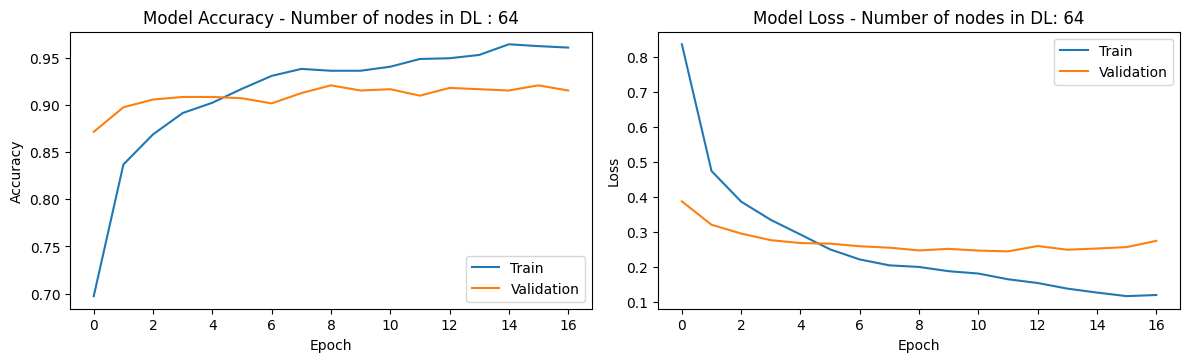

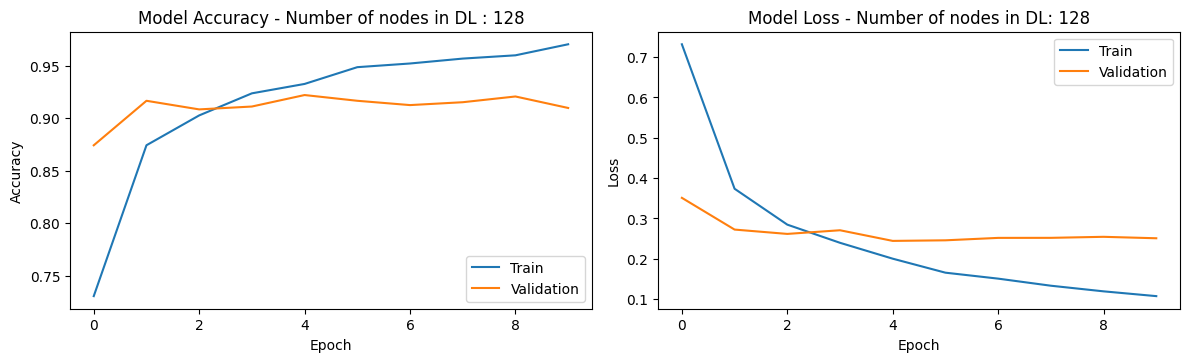

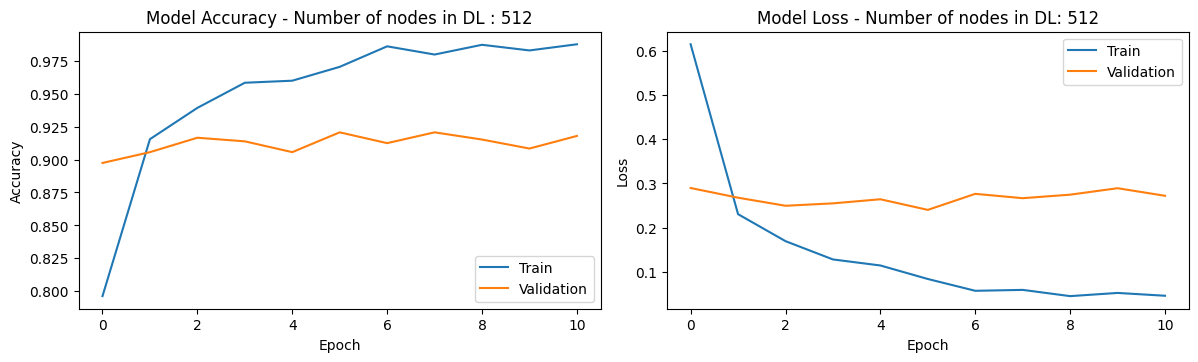

 Number of nodes in DL  Accuracy Diff Mean  Loss Diff Mean
                    64              0.0390          0.1041
                   128              0.0428          0.1158
                   512              0.0574          0.1816


In [37]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Creazione del DataFrame per la tabella finale

table_data = {'Number of nodes in DL': num_nodes, 'Accuracy Diff Mean': [], 'Loss Diff Mean': []}
# Plot delle curve di accuracy e loss per ogni storia di addestramento
for i, historyRMSprop in enumerate(historiesAdamdense):
    nodes = num_nodes[i]
    # Calcolo della media delle differenze tra le accuracy
    train_acc_diff = np.abs(np.array(historyRMSprop.history['accuracy']) - np.array(historyRMSprop.history['val_accuracy']))
    avg_acc_diff = np.mean(train_acc_diff)

    # Calcolo della media delle differenze tra le loss
    train_loss_diff = np.abs(np.array(historyRMSprop.history['loss']) - np.array(historyRMSprop.history['val_loss']))
    avg_loss_diff = np.mean(train_loss_diff)

    # Aggiunta dei valori nella tabella
    table_data['Accuracy Diff Mean'].append(avg_acc_diff)
    table_data['Loss Diff Mean'].append(avg_loss_diff)

    # Grafico dell'accuracy e della loss
    plt.figure(figsize=(12, 10))

    # Accuracy
    plt.subplot(3, 2, 1)
    plt.plot(historyRMSprop.history['accuracy'])
    plt.plot(historyRMSprop.history['val_accuracy'])
    plt.title(f'Model Accuracy - Number of nodes in DL : {nodes}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')

    # Legenda Accuracy
    acc_legend_text = ['Train', 'Validation']
    plt.legend(acc_legend_text, loc='lower right')


    # Loss
    plt.subplot(3, 2, 2)
    plt.plot(historyRMSprop.history['loss'])
    plt.plot(historyRMSprop.history['val_loss'])
    plt.title(f'Model Loss - Number of nodes in DL: {nodes}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')

    # Legenda Loss
    loss_legend_text = ['Train', 'Validation']
    plt.legend(loss_legend_text, loc='upper right')

    plt.tight_layout()
    plt.show()

# Creazione del DataFrame finale
table_df = pd.DataFrame(table_data)

# Stampa della tabella con formattazione migliore
print(table_df.to_string(index=False, float_format='%.4f'))

# Comparison between plots of accuracy and loss on validation set

- Adam, RMSProp

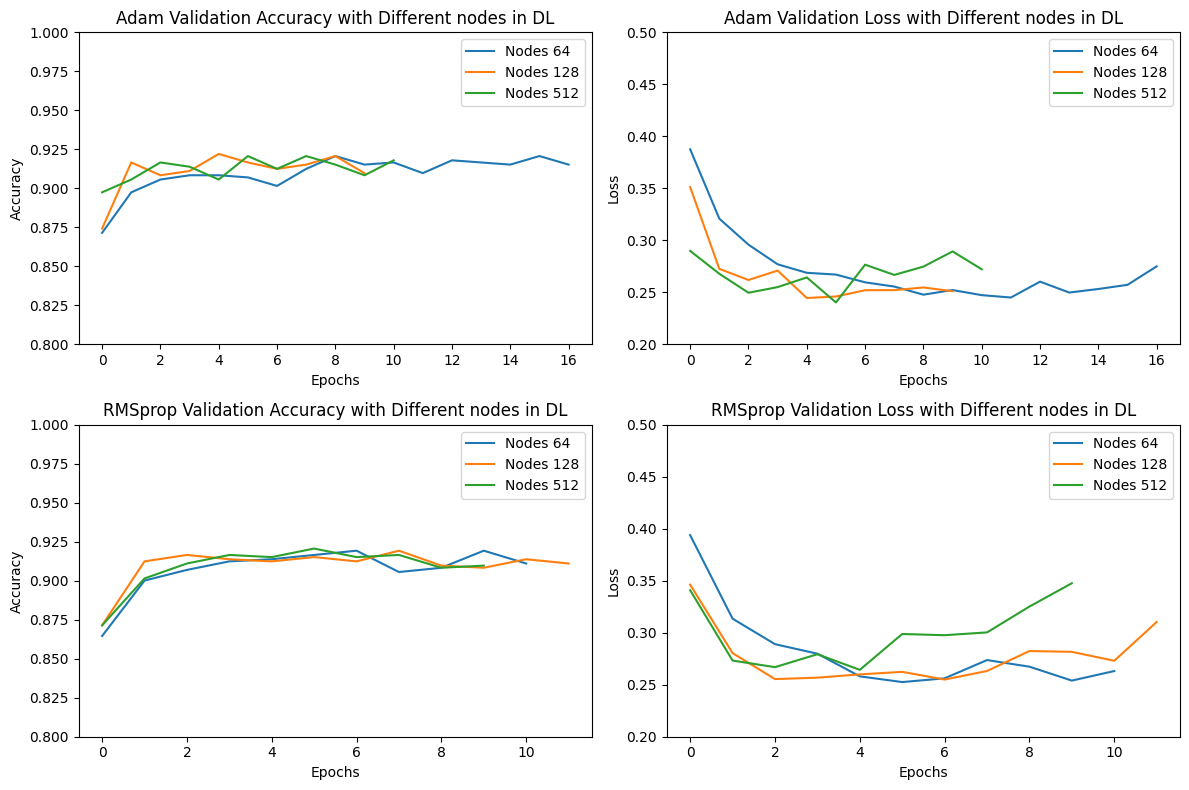

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Grafico delle accuracy e loss sul validation set Adam
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Grafico delle accuracy sul validation set Adam
for i, historyAdam in enumerate(historiesAdamdense):
    ax = axes[0, 0]
    ax.plot(historyAdam.history['val_accuracy'], label='Nodes {}'.format(num_nodes[i]))
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_ylim([0.8, 1])
ax.set_title('Adam Validation Accuracy with Different nodes in DL')
ax.legend()

# Grafico delle loss sul validation set Adam
for i, historyAdam in enumerate(historiesAdamdense):
    ax = axes[0, 1]
    ax.set_ylim([0.2, 0.5])
    ax.plot(historyAdam.history['val_loss'], label='Nodes {}'.format(num_nodes[i]))
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('Adam Validation Loss with Different nodes in DL')
ax.legend()

# Grafico delle accuracy sul validation set RMSprop
for i, historyRMSprop in enumerate(historiesRMSpropdense):
    ax = axes[1, 0]
    ax.plot(historyRMSprop.history['val_accuracy'], label='Nodes {}'.format(num_nodes[i]))
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_ylim([0.8, 1])
ax.set_title('RMSprop Validation Accuracy with Different nodes in DL')
ax.legend()

# Grafico delle loss sul validation set RMSprop
for i, historyRMSprop in enumerate(historiesRMSpropdense):
    ax = axes[1, 1]
    ax.plot(historyRMSprop.history['val_loss'], label='Nodes {}'.format(num_nodes[i]))
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_ylim([0.2, 0.5])
ax.set_title('RMSprop Validation Loss with Different nodes in DL')
ax.legend()

plt.tight_layout()
plt.show()

# Adam vs RMSProp optimizer

- Final plot of the best accuracy and Loss on validation set

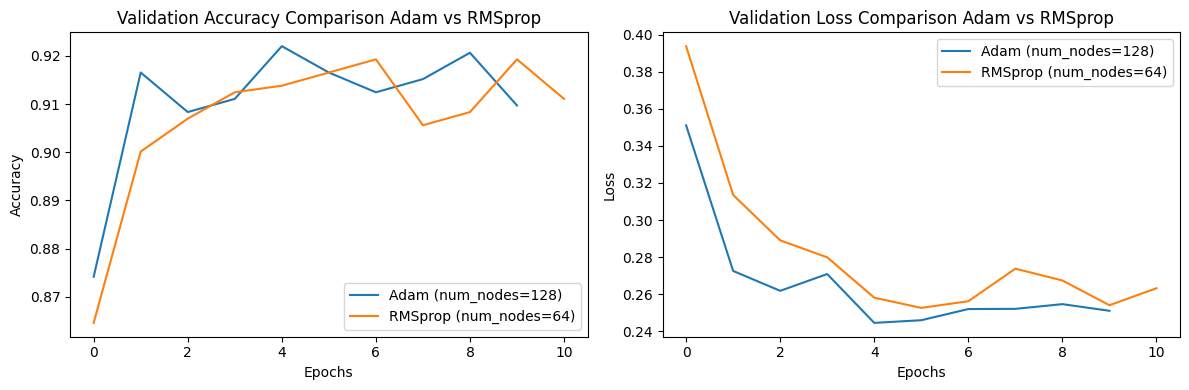

In [40]:
plt.figure(figsize=(12, 4))

# Accuracy Comparison
plt.subplot(1, 2, 1)
plt.plot(historiesAdamdense[1].history['val_accuracy'], label='Adam (num_nodes=128)')
plt.plot(historiesRMSpropdense[0].history['val_accuracy'], label='RMSprop (num_nodes=64)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Comparison Adam vs RMSprop')
plt.legend()

# Loss Comparison
plt.subplot(1, 2, 2)
plt.plot(historiesAdamdense[1].history['val_loss'], label='Adam (num_nodes=128)')
plt.plot(historiesRMSpropdense[0].history['val_loss'], label='RMSprop (num_nodes=64)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss Comparison Adam vs RMSprop')
plt.legend()

plt.tight_layout()
plt.show()

# #---------------------------------------------------

# Adam augmentation

1. best learning rate->0.001

2. best regularizer->0.0001

3. best number of dense nodes->128

In [43]:

def random_channel_flip(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image

new_data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),  # Ribalta orizzontalmente le immagini
        layers.RandomRotation(0.1),  # Ruota casualmente le immagini di 0.1 radianti
        layers.RandomTranslation(0.1, 0.1),  # Esegue una traslazione casuale delle immagini
        layers.Lambda(random_channel_flip),  # Ribalta casualmente i canali di colore delle immagini

    ]
)

In [44]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import RMSprop
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


# Dimensioni delle immagini di input
input_shape = (224, 224, 3)

# Numero di classi (categorie di fiori nel dataset)
num_classes = 5

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Carica l'architettura MobileNet preaddestrata
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)

# Congela i pesi dell'architettura preaddestrata
for layer in base_model.layers:
    layer.trainable = False

# Aggiunge i fully connected layers personalizzati con regolarizzazione L2 e dropout
regularization = tf.keras.regularizers.l2(0.0001)  # coefficiente di regolarizzazione
inputs = tf.keras.Input(shape=(224, 224, 3))
x = inputs
x = new_data_augmentation(x)
x = base_model(x)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu', kernel_regularizer=regularization)(x)
x = Dropout(0.5)(x)  # Aggiunta del dropout
x = BatchNormalization()(x)  # Aggiunta del batch normalization
predictions = Dense(num_classes, activation='softmax')(x)

# Crea il modello finale
model = Model(inputs=inputs, outputs=predictions)

# Definisci l'ottimizzatore con il tasso di apprendimento iniziale
optimizer = Adam(learning_rate=0.001)

# Compila il modello con l'ottimizzatore e la metrica di valutazione
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Stampa un riassunto del modello
model.summary()

# Definisci il percorso dei dati
data_dir = '/content/output'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/val'
test_dir = data_dir + '/test'

# Crea i generatori di immagini per l'addestramento e la validazione senza data augmentation
train_datagen= ImageDataGenerator(rescale=1./255)
val_datagen= ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Imposta i generatori di dati
batch_size = 32
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    valid_dir,
    target_size=(224,224),
    batch_size=batch_size,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)
# Addestra il modello
history = model.fit(
    train_generator,
    epochs=40,
    validation_data=val_generator,
    callbacks=[callback]
)

evaluateAdam_Aug = loss, accuracy = model.evaluate(test_generator)
model.save('drive/MyDrive/MobileNet_Adam_newAugmentation.h5')

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_44 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_21  (None, 1024)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_42 (Bat  (None, 1024)             4096      
 chNormalization)                                                
                                                          

In [45]:
print(evaluateAdam_Aug)

[0.27075526118278503, 0.9166666865348816]


#  Validation vs train plot with the new data augmentation

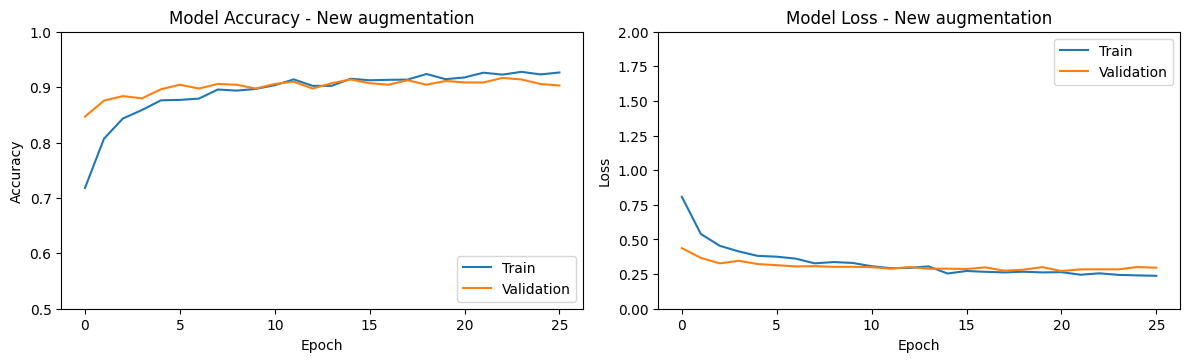

     Augmentation  Accuracy Diff Mean  Loss Diff Mean
 New augmentation              0.0188          0.0543


In [46]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Creazione del DataFrame per la tabella finale
table_data = {'Augmentation': ' New augmentation', 'Accuracy Diff Mean': [], 'Loss Diff Mean': []}

# Calcolo della media delle differenze tra le accuracy
train_acc_diff = np.abs(np.array(history.history['accuracy']) - np.array(history.history['val_accuracy']))
avg_acc_diff = np.mean(train_acc_diff)

# Calcolo della media delle differenze tra le loss
train_loss_diff = np.abs(np.array(history.history['loss']) - np.array(history.history['val_loss']))
avg_loss_diff = np.mean(train_loss_diff)

# Aggiunta dei valori nella tabella
table_data['Accuracy Diff Mean'].append(avg_acc_diff)
table_data['Loss Diff Mean'].append(avg_loss_diff)

# Grafico dell'accuracy e della loss
plt.figure(figsize=(12, 10))

# Accuracy
plt.subplot(3, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title(f'Model Accuracy - New augmentation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim([0.5, 1])

# Legenda Accuracy
acc_legend_text = ['Train', 'Validation']
plt.legend(acc_legend_text, loc='lower right')


# Loss
plt.subplot(3, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Model Loss - New augmentation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim([0, 2])

# Legenda Loss
loss_legend_text = ['Train', 'Validation']
plt.legend(loss_legend_text, loc='upper right')

plt.tight_layout()
plt.show()

# Creazione del DataFrame finale
table_df = pd.DataFrame(table_data)

# Stampa della tabella con formattazione migliore
print(table_df.to_string(index=False, float_format='%.4f'))

# RMSprop augmentation

In [47]:
def random_channel_flip(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image

new_data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),  # Ribalta orizzontalmente le immagini
        layers.RandomRotation(0.1),  # Ruota casualmente le immagini di 0.1 radianti
        layers.RandomTranslation(0.1, 0.1),  # Esegue una traslazione casuale delle immagini
        layers.Lambda(random_channel_flip),  # Ribalta casualmente i canali di colore delle immagini
    ]
)

In [48]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import RMSprop
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


# Dimensioni delle immagini di input
input_shape = (224, 224, 3)

# Numero di classi (categorie di fiori nel dataset)
num_classes = 5

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Carica l'architettura MobileNet preaddestrata
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)

# Congela i pesi dell'architettura preaddestrata
for layer in base_model.layers:
    layer.trainable = False

# Aggiunge i fully connected layers personalizzati con regolarizzazione L2 e dropout
regularization = tf.keras.regularizers.l2(0.0001)  # coefficiente di regolarizzazione
inputs = tf.keras.Input(shape=(224, 224, 3))
x = inputs
x = new_data_augmentation(x)
x = base_model(x)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(64, activation='relu', kernel_regularizer=regularization)(x)
x = Dropout(0.5)(x)  # Aggiunta del dropout
x = BatchNormalization()(x)  # Aggiunta del batch normalization
predictions = Dense(num_classes, activation='softmax')(x)

# Crea il modello finale
model = Model(inputs=inputs, outputs=predictions)

# Definisci l'ottimizzatore con il tasso di apprendimento iniziale
optimizer = RMSprop(learning_rate=0.001)

# Compila il modello con l'ottimizzatore e la metrica di valutazione
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Stampa un riassunto del modello
model.summary()

# Definisci il percorso dei dati
data_dir = '/content/output'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/val'
test_dir = data_dir +'/test'

# Crea i generatori di immagini per l'addestramento e la validazione senza data augmentation
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
# Imposta i generatori di dati
batch_size = 32
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    valid_dir,
    target_size=(224,224),
    batch_size=batch_size,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

# Addestra il modello
history1 = model.fit(
    train_generator,
    epochs=40,
    validation_data=val_generator,
    callbacks=[callback]
)

evaluateRMSprop_Aug = loss, accuracy = model.evaluate(test_generator)
model.save('drive/MyDrive/MobileNet_RMSprop_newAugmentation.h5')

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_46 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_22  (None, 1024)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_44 (Bat  (None, 1024)             4096      
 chNormalization)                                                
                                                          

In [49]:
print(evaluateRMSprop_Aug)

[0.2574015259742737, 0.9059139490127563]


#  Validation vs train plot with the new data augmentation

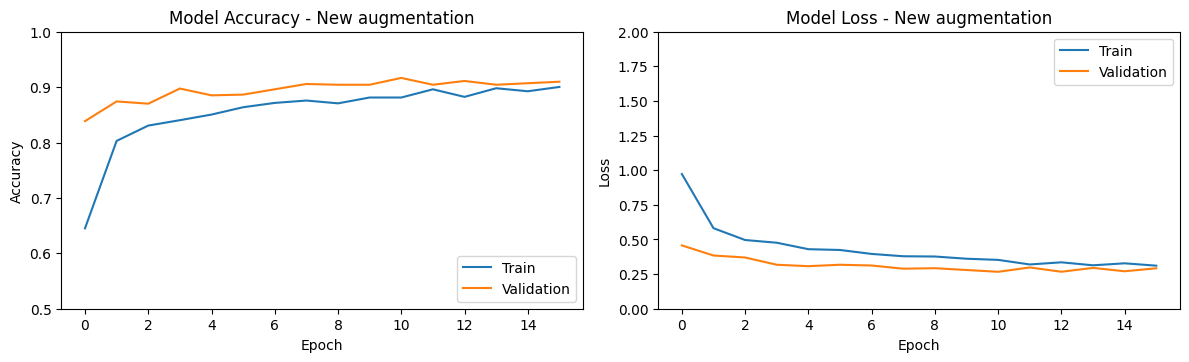

     Augmentation  Accuracy Diff Mean  Loss Diff Mean
 New augmentation              0.0395          0.1148


In [50]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Creazione del DataFrame per la tabella finale
table_data = {'Augmentation': ' New augmentation', 'Accuracy Diff Mean': [], 'Loss Diff Mean': []}

# Calcolo della media delle differenze tra le accuracy
train_acc_diff = np.abs(np.array(history1.history['accuracy']) - np.array(history1.history['val_accuracy']))
avg_acc_diff = np.mean(train_acc_diff)

# Calcolo della media delle differenze tra le loss
train_loss_diff = np.abs(np.array(history1.history['loss']) - np.array(history1.history['val_loss']))
avg_loss_diff = np.mean(train_loss_diff)

# Aggiunta dei valori nella tabella
table_data['Accuracy Diff Mean'].append(avg_acc_diff)
table_data['Loss Diff Mean'].append(avg_loss_diff)

# Grafico dell'accuracy e della loss
plt.figure(figsize=(12, 10))

# Accuracy
plt.subplot(3, 2, 1)
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title(f'Model Accuracy - New augmentation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim([0.5, 1])

# Legenda Accuracy
acc_legend_text = ['Train', 'Validation']
plt.legend(acc_legend_text, loc='lower right')


# Loss
plt.subplot(3, 2, 2)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title(f'Model Loss - New augmentation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim([0, 2])

# Legenda Loss
loss_legend_text = ['Train', 'Validation']
plt.legend(loss_legend_text, loc='upper right')

plt.tight_layout()
plt.show()

# Creazione del DataFrame finale
table_df = pd.DataFrame(table_data)

# Stampa della tabella con formattazione migliore
print(table_df.to_string(index=False, float_format='%.4f'))

# Adam vs RMSProp optimizer

- Final plot of the best accuracy and Loss on validation set

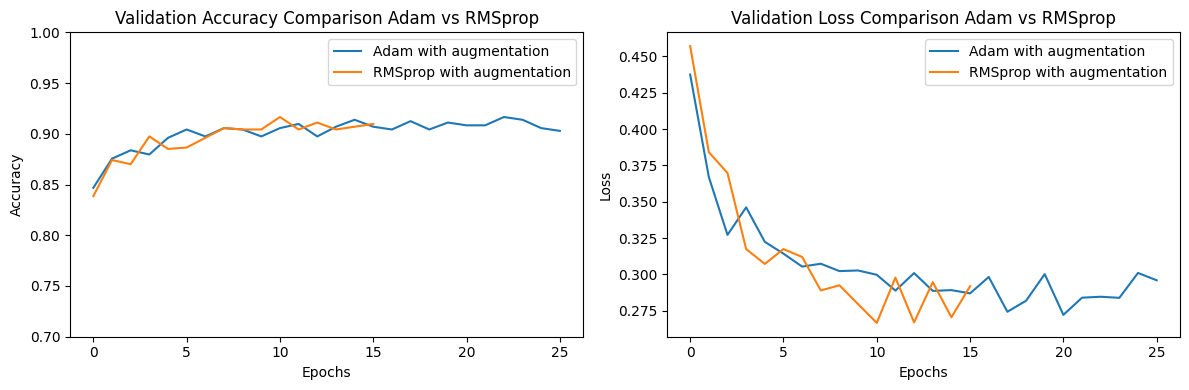

In [51]:
plt.figure(figsize=(12, 4))

# Accuracy Comparison
plt.subplot(1, 2, 1)
plt.plot(history.history['val_accuracy'], label='Adam with augmentation')
plt.plot(history1.history['val_accuracy'], label='RMSprop with augmentation')
plt.ylim(0.7, 1)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Comparison Adam vs RMSprop')
plt.legend()

# Loss Comparison
plt.subplot(1, 2, 2)
plt.plot(history.history['val_loss'], label='Adam with augmentation')
plt.plot(history1.history['val_loss'], label='RMSprop with augmentation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss Comparison Adam vs RMSprop')
plt.legend()

plt.tight_layout()
plt.show()

# #------------------------------------------

# Comparison between the best models of the first 3 blocks and the models obtained with the new data augmentation

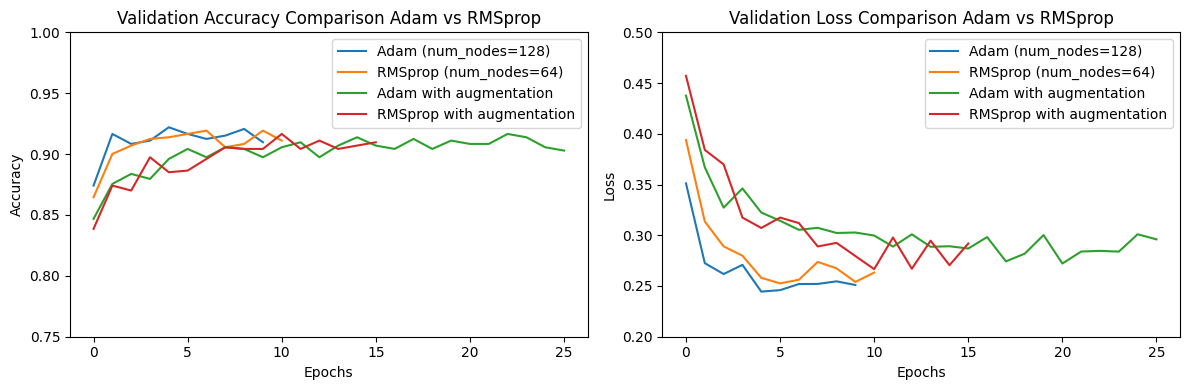

In [52]:
plt.figure(figsize=(12, 4))

# Accuracy Comparison
plt.subplot(1, 2, 1)
plt.plot(historiesAdamdense[1].history['val_accuracy'], label='Adam (num_nodes=128)')
plt.plot(historiesRMSpropdense[0].history['val_accuracy'], label='RMSprop (num_nodes=64)')
plt.plot(history.history['val_accuracy'], label='Adam with augmentation')
plt.plot(history1.history['val_accuracy'], label='RMSprop with augmentation')
plt.ylim(0.75, 1)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Comparison Adam vs RMSprop')
plt.legend()

# Loss Comparison
plt.subplot(1, 2, 2)
plt.plot(historiesAdamdense[1].history['val_loss'], label='Adam (num_nodes=128)')
plt.plot(historiesRMSpropdense[0].history['val_loss'], label='RMSprop (num_nodes=64)')
plt.plot(history.history['val_loss'], label='Adam with augmentation')
plt.plot(history1.history['val_loss'], label='RMSprop with augmentation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0.2, 0.5)
plt.title('Validation Loss Comparison Adam vs RMSprop')
plt.legend()

plt.tight_layout()
plt.show()

The best model for MobileNet is the one with the following parameters fixed:

1. learning rate 0.001
2. regularizer l2 0.0001
3. num_nodes=128
4. Basic data augmentation
5. Adam optimizer